In [503]:
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

ESTABLISHING PARAMETERS

In [504]:
# Define the cryptocurrency and date range for data retrieval using yfinance
crypto = 'BTC-USD'
#Setting a 10 year window, chosen arbitrarily
start_date = '2015-08-01'
#end date is set to the current date
end_date = dt.datetime.now().strftime('%Y-%m-%d')

In [505]:
#Downloading daily Bitcoin pricing data from Yahoo Finance
BTC_pricing = yf.download(crypto, start=start_date, end=end_date, interval='1d')
BTC_pricing.copy()
BTC_pricing

C:\Users\ryley\AppData\Local\Temp\ipykernel_21144\1168999791.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  BTC_pricing = yf.download(crypto, start=start_date, end=end_date, interval='1d')
[*********************100%***********************]  1 of 1 completed

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2015-08-01,281.601013,284.932007,278.112000,284.686005,18995000
2015-08-02,282.614014,283.032013,277.528992,280.449005,17722200
2015-08-03,281.226990,285.471008,280.233002,282.806000,21474100
2015-08-04,285.217987,285.714996,281.225006,281.225006,21908700
2015-08-05,281.881989,285.501007,281.488007,284.846985,20128000
...,...,...,...,...,...
2025-08-13,123344.062500,123682.453125,118939.632812,120168.976562,90904808795
2025-08-14,118359.578125,124457.117188,117254.882812,123339.398438,104055627395


In [506]:
#Cleaning date, removing irrelevant columns and setting date as df index
BTC_pricing.reset_index(inplace=True)
BTC_pricing = BTC_pricing[['Date',  'Close']].copy()
#BTC_pricing.set_index('Date', inplace=True)
BTC_pricing['Date'] = pd.to_datetime(BTC_pricing['Date'])

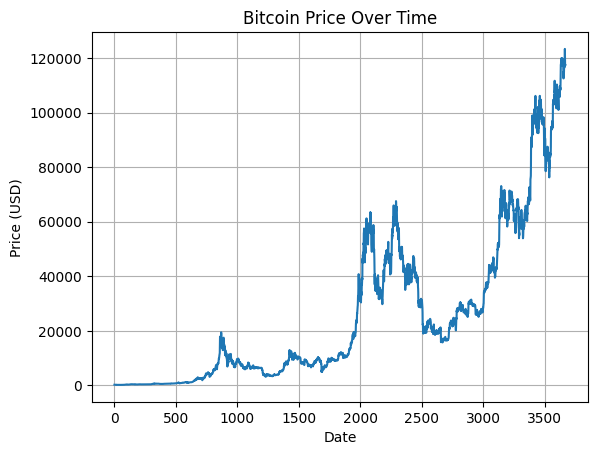

In [507]:
#visualizing the Bitcoin pricing data for last 10 years
plt.plot(BTC_pricing.index, BTC_pricing['Close'])
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid()


In [508]:
#Setting copy of BTC_pricing to avoid slicing issues later
#BTC_pricing = BTC_pricing.copy()

In [509]:
#Setting Close price lag features for 1, 2, and 3 days to use as ML features

#Loops through range of 1 to 3, creating new column with a lag shift of 1, 2, and 3 days respectively
for i in range(1,4):
    BTC_pricing[f'{i}_Days_Close_Price_Lag'] = BTC_pricing['Close'].shift(i)

BTC_pricing.dropna(inplace=True)  #Dropping rows with NaN values after lagging
BTC_pricing

Price,Date,Close,1_Days_Close_Price_Lag,2_Days_Close_Price_Lag,3_Days_Close_Price_Lag
Ticker,,BTC-USD,,,
3,2015-08-04,285.217987,281.226990,282.614014,281.601013
4,2015-08-05,281.881989,285.217987,281.226990,282.614014
5,2015-08-06,278.576996,281.881989,285.217987,281.226990
6,2015-08-07,279.584991,278.576996,281.881989,285.217987
7,2015-08-08,260.997009,279.584991,278.576996,281.881989
...,...,...,...,...,...
3665,2025-08-13,123344.062500,120172.906250,118731.445312,119306.757812
3666,2025-08-14,118359.578125,123344.062500,120172.906250,118731.445312
3667,2025-08-15,117398.351562,118359.578125,123344.062500,120172.906250


In [510]:
#Function to set BTC pricing dataframe as numpy array for ML model input

#Drop any rows with NaN values
#BTC_pricing.dropna(inplace=True)

#Convert to numpy array
BTC_pricing_np = BTC_pricing.to_numpy()

#Set dates array as date column from BTC pricing dataframe, convert to datetime format with day precision
dates = BTC_pricing_np[:,0].astype('datetime64[D]')

#Set lagged close prices (day lags 1 to 3) as separate numpy array, converting to float values, reshaping each day (with corresponding lags 1,2,3) to array with 3 rows and 1 column (1 feature for ML model input)
lag_close = BTC_pricing[['1_Days_Close_Price_Lag', '2_Days_Close_Price_Lag', '3_Days_Close_Price_Lag']].values.astype(float)
lag_close = lag_close.reshape((lag_close.shape[0], lag_close.shape[1], 1))

#Set current close prices as a separate numpy array, converting to float values
current_close = BTC_pricing_np[:,1].astype(float)

current_close

array([   285.21798706,    281.88198853,    278.57699585, ...,
       117398.3515625 , 117491.3515625 , 117453.0625    ], shape=(3667,))

In [511]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Flatten X for scaling, then reshape back
lag_close_scaled = scaler_X.fit_transform(lag_close.reshape(-1,1)).reshape(lag_close.shape)
current_close_scaled = scaler_y.fit_transform(current_close.reshape(-1,1))

In [512]:
#Separating train/test data into 70/30 split

#Setting train split as 70% of the total number of rows from dataset (BTC pricing days)
train_split = int(len(dates) * 0.7)

#Slicing date, lagged close prices, and current close prices into separate training arrays (with initial 70% of the data)
train_dates = dates[:train_split]
train_lag_close = lag_close_scaled[:train_split]
train_current_close = current_close_scaled[:train_split]

#Setting validation split as 20% of the total number of rows from dataset (BTC pricing days)
val_split = int(len(dates) * 0.2)

#Slicing date, lagged close prices, and current close prices into separate validation arrays (with next 20% of the data)
val_dates = dates[train_split:train_split + val_split]
val_lag_close = lag_close_scaled[train_split:train_split + val_split]
val_current_close = current_close_scaled[train_split:train_split + val_split]

#Setting test split as 10% of the total number of rows from dataset (BTC pricing days)
test_split = int(len(dates) * 0.1)

#Slicing date, lagged close prices, and current close prices into separate test arrays (with last 10% of the data)
test_dates = dates[train_split + val_split:]
test_lag_close = lag_close_scaled[train_split + val_split:]
test_current_close = current_close_scaled[train_split + val_split:]



In [513]:
#Testing tensorflow model which works best for time series data

#Setting NN model
model = Sequential([
	layers.Input((3,1)), #input shape of lagged close prices (3 days of lag prices) input as 1 feature (1 column)
	layers.LSTM(64), #64 neurons (common choice, played around with different values) for learning layer
    layers.Dense(32, activation='relu'), #layer takes 64 neurons output and applies ReLU non-linearity to model (to learn complex relationships)
    layers.Dense(32, activation='relu'), #same as above, increases model ability to learn complex relationships
    layers.Dense(1)  #Output layer for predicting the next close price (singular float value output)
])

In [514]:
#Compiling above model. Adam Optimizer to update weights within neurons during training (most common choice for optimizer that I found online, learning rate of 0.001 most common choice as well) 
#Loss function set to evaluate and minimized mean squared error between prediction and actual BTC close price during training 
#Outputs more comprehensible mean absolute error metric for model performance evaluation
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

In [515]:
#training model with training data, validating with validation data, trial with 200 epochs (to check for overfitting as well))
fitted_model = model.fit(train_lag_close, train_current_close, epochs=100, validation_data=(val_lag_close, val_current_close),verbose=1)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0220 - mae: 0.0903 - val_loss: 0.0558 - val_mae: 0.2022
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114 - mae: 0.0697 - val_loss: 0.0248 - val_mae: 0.1253
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - mae: 0.0529 - val_loss: 0.0083 - val_mae: 0.0679
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - mae: 0.0261 - val_loss: 0.0016 - val_mae: 0.0260
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5889e-04 - mae: 0.0073 - val_loss: 3.7554e-04 - val_mae: 0.0114
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5757e-05 - mae: 0.0046 - val_loss: 2.1242e-04 - val_mae: 0.0089
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0869e-05 - mae: 0.0045 - val_loss: 1.7329e-04 - val_mae: 0.0082
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9968e-05 - mae: 0.0044 - val_loss: 1.5983e-04 - val_mae: 0.0079
Epoch 9/100
81/81 ━━━━━━━━━━━━━━

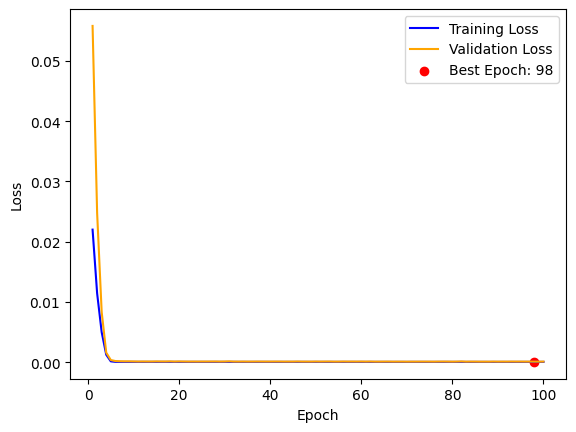

range(1, 101)

In [516]:

#Checking which epoch of training was best to check for overkill on number of epochs/ overfitting
#Pulling training and validation loss from fitted model (above) history
train_loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']

#set number of epochs from above model parameters starting at 1 (not index 0)
epochs = range(1, len(train_loss)+1)

# Find the epoch with minimum validation loss (epoch with lowest validation loss), any epoch beyond this point is probably overfitting (val loss increasing)
best_epoch_0 = np.argmin(val_loss)
best_epoch = best_epoch_0 +1  # Adding 1 to convert from index to "best" epoch number
best_val_loss = val_loss[best_epoch_0] #Best validation loss starting at index 0

#plotting training and validation loss to visualize model performance over epochs
#Plotting training loss vs number of epochs on x axis
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
#Plotting validation loss vs number of epochs on x axis
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')

# Highlighting the best epoch with minimum validation loss (starting at index 1)
plt.scatter(best_epoch, best_val_loss, color='red', label=f'Best Epoch: {best_epoch}')

#Setting labels and legend 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
epochs

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Text(0.5, 1.0, 'Training Data: Predicted vs Actual Close Prices')

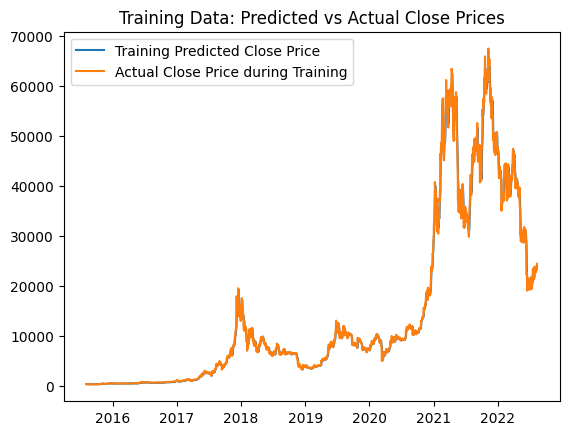

In [517]:
train_predictions_scaled = model.predict(train_lag_close)
train_predictions = scaler_y.inverse_transform(train_predictions_scaled).flatten()
plt.plot(train_dates, train_predictions)
plt.plot(train_dates, current_close[:train_split])
plt.legend(['Training Predicted Close Price', 'Actual Close Price during Training'])
plt.title('Training Data: Predicted vs Actual Close Prices')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Text(0.5, 1.0, 'Validation Data: Predicted vs Actual Close Prices')

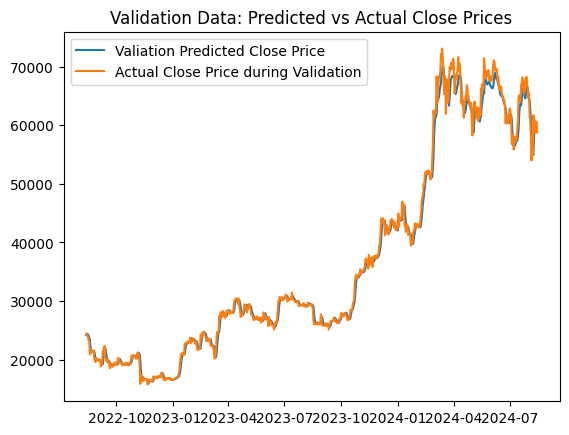

In [518]:
val_predictions_scaled = model.predict(val_lag_close)
val_predictions = scaler_y.inverse_transform(val_predictions_scaled).flatten()
val_current_close = scaler_y.inverse_transform(val_current_close).flatten()
plt.plot(val_dates, val_predictions)
plt.plot(val_dates, val_current_close)
plt.legend(['Valiation Predicted Close Price', 'Actual Close Price during Validation'])
plt.title('Validation Data: Predicted vs Actual Close Prices')

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Text(0.5, 1.0, 'Test Data: Predicted vs Actual Close Prices')

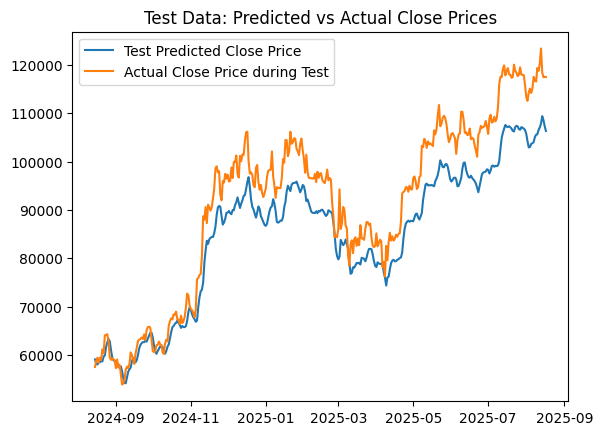

In [519]:
test_predictions_scaled = model.predict(test_lag_close)
test_predictions = scaler_y.inverse_transform(test_predictions_scaled).flatten()
test_current_close = scaler_y.inverse_transform(test_current_close).flatten()
plt.plot(test_dates, test_predictions)
plt.plot(test_dates, test_current_close)
plt.legend(['Test Predicted Close Price', 'Actual Close Price during Test'])
plt.title('Test Data: Predicted vs Actual Close Prices')

In [520]:
#Predicting the next day's close price using the last 3 days of lagged close prices from the dataset
last_3_days_lag = lag_close_scaled[-1].reshape((1,3,1))
next_day_prediction_scaled = model.predict(last_3_days_lag)
next_day_prediction = scaler_y.inverse_transform(next_day_prediction_scaled).flatten()[0]
next_day_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


np.float32(106311.914)